# Variational Autoencoder

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import numpy as np
np.random.seed(42)

from keras.datasets import mnist
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import metrics
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))
K.get_session().run(tf.global_variables_initializer())

import sys
sys.path.append('../util/')
from util import plotProgress

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000,-1)
X_test = X_test.reshape(10000,-1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [3]:
epochs = 100
batch = 128
latent_dim = 2
inter_dim1 = 400
# inter_dim2 = 128
# inter_dim3 = 64
# inter_dim4 = 10
optimizer = 'adam'
rate_recon = 0.5

In [4]:
def sampling(args):
    z_mean,z_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0],latent_dim),mean=0,stddev=1)
    return z_mean+K.exp(z_log_var/2)*epsilon

In [5]:
def lossVAE(z_mean, z_sigma_log):
    def loss(tensor_input, tensor_decode):
        loss_recon =  metrics.binary_crossentropy(K.flatten(tensor_input), K.flatten(tensor_decode))
        loss_KL = - 0.5 * K.sum(1 + z_sigma_log - K.square(z_mean) - K.exp(z_sigma_log), axis=-1)
        return rate_recon*loss_recon + (1-rate_recon)*loss_KL
    return loss

In [6]:
inputs=Input(shape = (X_train.shape[1],))
x = inputs
x = Dense(inter_dim1,activation='relu')(x)
# x = Dense(inter_dim2,activation='relu')(x)
# x = Dense(inter_dim3,activation='relu')(x)
# x = Dense(inter_dim4,activation='relu')(x)
z_mean=Dense(latent_dim,activation='linear')(x)
z_log_var=Dense(latent_dim,activation='linear')(x)
encoder = Model(inputs,z_mean,name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               314000    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 802       
Total params: 314,802
Trainable params: 314,802
Non-trainable params: 0
_________________________________________________________________


In [7]:
z=Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])
latent=Input(shape=(latent_dim,))
# x=Dense(inter_dim4,activation='relu')(latent)
# x=Dense(inter_dim3,activation='relu')(x)
# x=Dense(inter_dim2,activation='relu')(latent)
x=Dense(inter_dim1,activation='relu')(latent)
x=Dense(X_train.shape[1],activation='sigmoid')(x)
decoder=Model(latent,x)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 400)               1200      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               314384    
Total params: 315,584
Trainable params: 315,584
Non-trainable params: 0
_________________________________________________________________


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.1531 - val_loss: 0.1324
Epoch 2/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.1321 - val_loss: 0.1317
Epoch 3/100
60000/60000 [==============================] - 4s 64us/step - loss: 0.1317 - val_loss: 0.1314
Epoch 4/100
60000/60000 [==============================] - 3s 42us/step - loss: 0.1316 - val_loss: 0.1315
Epoch 5/100
60000/60000 [==============================] - 4s 61us/step - loss: 0.1316 - val_loss: 0.1314
Epoch 6/100
60000/60000 [==============================] - 3s 42us/step - loss: 0.1316 - val_loss: 0.1317
Epoch 7/100
60000/60000 [==============================] - 3s 49us/step - loss: 0.1316 - val_loss: 0.1314
Epoch 8/100
60000/60000 [==============================] - 4s 66us/step - loss: 0.1316 - val_loss: 0.1315
Epoch 9/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1316 - val_loss: 0.1

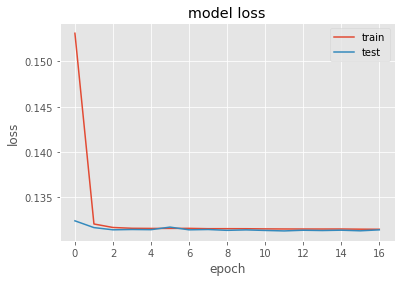

In [8]:
autoencoder = Model(inputs,decoder(z))
autoencoder.compile(optimizer = optimizer,loss = lossVAE(z_mean,z_log_var))
es_cb = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, mode = 'auto')
history = autoencoder.fit(X_train, X_train,
                epochs = epochs,
                batch_size = batch,
                shuffle = True,
                callbacks = [es_cb],
                validation_data = (X_test,X_test))
plotProgress(history)

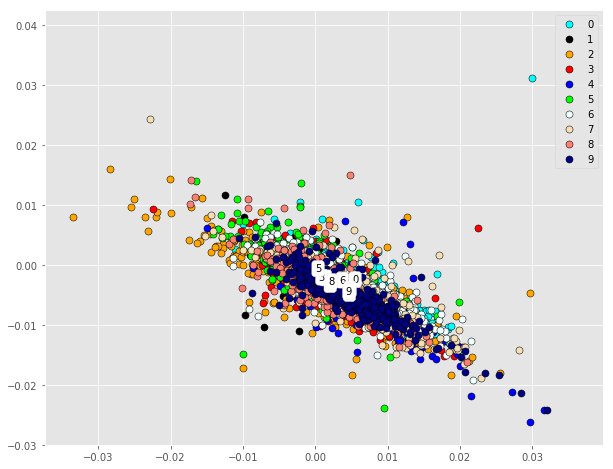

In [9]:
pred = encoder.predict(X_test)
cmap = ['cyan','black','orange','red','blue','lime','azure','wheat','salmon','navy']
fig,ax = plt.subplots(figsize = (10,8))
for i in range(10):
    ax.scatter(pred[y_test == i,0],pred[y_test == i,1],
               edgecolors = 'black',
               c = cmap[i],
               label = str(i),
               s=50)
    ax.annotate(str(i),(pred[y_test == i,0].mean(),pred[y_test == i,1].mean()),
               bbox = dict(boxstyle = 'round', fc = 'w'))
plt.legend()
plt.savefig('images/clusters_0.5.png',bbox_inches='tight')

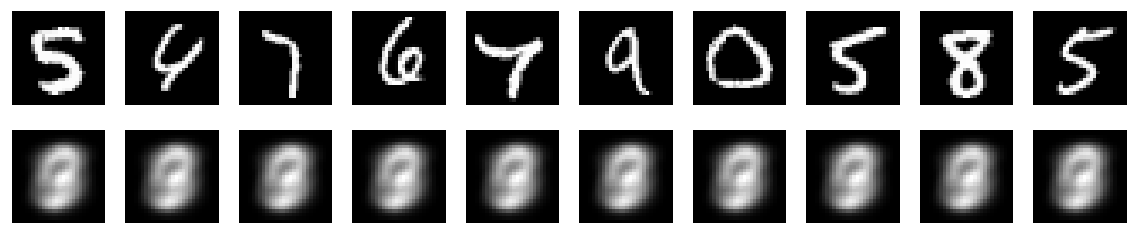

In [10]:
# get decoded digits
reconstructed = decoder.predict(pred)
# plot decoded
n = 10
row = 12
fig = plt.figure(figsize = (20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i + row * n].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i + row * n].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
fig.savefig('images/digits_0.5.png',bbox_inches='tight')